# Metodos en python para extracción de datos

Codigo en python el cual realiza la conexion a base de datos y exporta en formato excel los datos historicos de despacho mediante la función obtener_despachos, ademas mediante la función obtener_eventos_rastreo_gps podemos traer la data de un vehiculo en especifico con su detalle operativo


In [1]:
pip install mysql-connector-python==8.0.33

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


In [ ]:
import mysql.connector
from mysql.connector import Error
import os
import csv

# Función para conectar a la base de datos
def conectar_bd(database):
    try:
        conexion = mysql.connector.connect(
            host=os.getenv("DB_HOST", "147.93.47.161"),
            user=os.getenv("DB_USER", "masterbus"),
            password=os.getenv("DB_PASSWORD", "9@#$%&yhif"),
            database=database
        )
        if conexion.is_connected():
            print(f"✅ Conexión a la base de datos {database} establecida.")
            return conexion
    except Error as e:
        print(f"❌ Error al conectar a MySQL ({database}): {e}")
        return None

# Función para obtener el esquema de la base de datos
def obtener_esquema(conexion):
    if not conexion:
        print("❌ No hay conexión a la base de datos.")
        return None

    try:
        cursor = conexion.cursor()
        query = """
            SELECT TABLE_NAME, COLUMN_NAME, DATA_TYPE, COLUMN_TYPE
            FROM INFORMATION_SCHEMA.COLUMNS
            WHERE TABLE_SCHEMA = %s
        """
        cursor.execute(query, (conexion.database,))
        resultado = cursor.fetchall()

        esquema = {}
        for tabla, columna, tipo, columna_tipo in resultado:
            if tabla not in esquema:
                esquema[tabla] = []
            esquema[tabla].append({"columna": columna, "tipo": tipo, "detalle": columna_tipo})

        cursor.close()
        return esquema
    except Error as e:
        print(f"❌ Error al obtener el esquema: {e}")
        return None

# Función para obtener despachos y exportarlos a CSV
# Genera una archivo CSV con los despachos entre las fechas indicadas
# Los campos exportados son: fecha_inicial, hora_inicial_plan, hora_inicial_real, hora_inicial_aux, fecha_final,
# hora_final_plan, hora_final_real, hora_final_aux, fk_ruta, pasajeros, distancia, fk_vehiculo, fk_conductor,
# estado_despacho, pk_intervalo_despacho, pk_informacion_registradora
# Los parámetros son:
# - conexion: la conexión a la base de datos
# - fecha_ini: fecha inicial para filtrar los despachos
# - fecha_fin: fecha final para filtrar los despachos
# - archivo_csv: nombre del archivo CSV donde se exportarán los despachos
# Retorna una lista con los despachos obtenidos o None si no se pudo obtener la información
# En donde cada columna del archivo CSV corresponde a:
# - FECHA_INICIAL Fecha real del despacho
# - HORA_INICIAL_PLAN Hora planificada de inicio del despacho
# - HORA_INICIAL_REAL Hora real de inicio del despacho
# - HORA_INICIAL_AUX Hora de inicio del despacho obtenida de la información registradora
# - FECHA_FINAL Fecha real de finalización del despacho
# - HORA_FINAL_PLAN Hora planificada de finalización del despacho
# - HORA_FINAL_REAL Hora real de finalización del despacho
# - HORA_FINAL_AUX Hora de finalización del despacho obtenida de la información registradora
# - FK_RUTA Llave foránea de la ruta
# - PASAJEROS Número de pasajeros
# - DISTANCIA Distancia recorrida
# - FK_VEHICULO Llave foránea del vehículo
# - FK_CONDUCTOR Llave foránea del conductor
# - ESTADO_DESPACHO Estado del despacho cuyos valores posibles son: 0 No controlado, 2 Controlado (Adelantado ó Atrasado), 3  Controlado (En tiempo permitido / holgura), 4 Terminado manualmente
# - PK_INTERVALO_DESPACHO Llave primaria del intervalo de despacho
def obtener_despachos(conexion, fecha_ini, fecha_fin, archivo_csv="despachos.csv"):
    if not conexion:
        print("❌ No hay conexión a la base de datos.")
        return None

    try:
        cursor = conexion.cursor(dictionary=True)
        query = """
            SELECT FECHA_INICIAL, HORA_INICIAL_PLAN, HORA_INICIAL_REAL, HORA_INICIAL_AUX, FECHA_FINAL,
                   HORA_FINAL_PLAN, HORA_FINAL_REAL, HORA_FINAL_AUX, FK_RUTA, PASAJEROS, DISTANCIA,
                   FK_VEHICULO, FK_CONDUCTOR, ESTADO_DESPACHO, PK_INTERVALO_DESPACHO, PK_INFORMACION_REGISTRADORA
            FROM
            (
                SELECT PK_INTERVALO_DESPACHO, FECHA_INICIAL, HORA_INICIAL AS HORA_INICIAL_PLAN,
                       (SELECT HORA_REAL FROM tbl_planilla_despacho WHERE FK_INTERVALO_DESPACHO = PK_INTERVALO_DESPACHO AND TIPO_PUNTO = 1) AS HORA_INICIAL_REAL,
                       FECHA_FINAL, HORA_FINAL AS HORA_FINAL_PLAN,
                       (SELECT HORA_REAL FROM tbl_planilla_despacho WHERE FK_INTERVALO_DESPACHO = PK_INTERVALO_DESPACHO AND TIPO_PUNTO = 3) AS HORA_FINAL_REAL,
                       (SELECT ESTADO_DESPACHO FROM tbl_planilla_despacho WHERE FK_INTERVALO_DESPACHO = PK_INTERVALO_DESPACHO AND TIPO_PUNTO = 3) AS ESTADO_DESPACHO
                FROM tbl_intervalo_despacho
                WHERE FECHA_INICIAL BETWEEN %s AND %s AND ESTADO = 1
            ) AS ta
            INNER JOIN
            (
                SELECT HORA_SALIDA_BASE_SALIDA AS HORA_INICIAL_AUX, HORA_INGRESO AS HORA_FINAL_AUX, FK_RUTA,
                       DIFERENCIA_NUM AS PASAJEROS, DISTANCIA_METROS AS DISTANCIA, FK_VEHICULO, FK_CONDUCTOR,
                       FK_INTERVALO_DESPACHO, PK_INFORMACION_REGISTRADORA
                FROM tbl_informacion_registradora
                WHERE FECHA_SALIDA_BASE_SALIDA BETWEEN %s AND %s
            ) AS tb
            ON ta.PK_INTERVALO_DESPACHO = tb.FK_INTERVALO_DESPACHO
        """
        cursor.execute(query, (fecha_ini, fecha_fin, fecha_ini, fecha_fin))
        resultados = cursor.fetchall()

        if not resultados:
            print("⚠️ No hay registros de despachos para exportar.")
            return None

        # Guardar resultados en CSV
        with open(archivo_csv, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.DictWriter(file, fieldnames=resultados[0].keys())
            writer.writeheader()
            writer.writerows(resultados)

        print(f"✅ Datos exportados en '{archivo_csv}'.")
        cursor.close()
        return archivo_csv
    except Error as e:
        print(f"❌ Error al obtener los despachos: {e}")
        return None


# Función para cerrar la conexión a la base de datos
def cerrar_conexion(conexion):
    if conexion and conexion.is_connected():
        conexion.close()
        print("✅ Conexión cerrada correctamente.")

# Función principal
if __name__ == "__main__":
    conexion_principal = conectar_bd("bd_montebello_rdw") # Consolidados de rutas y despachos ,, resumen
    conexion_gps = conectar_bd("bd_montebello_rdw_gps") # neventos de vehiculos

    if conexion_principal and conexion_gps:
        # Obtener esquemas de las bases de datos ---  Solo si es necesario
        # esquema_principal = obtener_esquema(conexion_principal)
        # esquema_gps = obtener_esquema(conexion_gps)

        # Obtener datos de despachos ----  Lo siguiente a manera de ejemplo

        fecha_ini = '2024-04-16'
        fecha_fin = '2025-03-03'
        obtener_despachos(conexion_principal, fecha_ini, fecha_fin)


    cerrar_conexion(conexion_principal)
    cerrar_conexion(conexion_gps)


✅ Conexión a la base de datos bd_montebello_rdw establecida.
✅ Conexión a la base de datos bd_montebello_rdw_gps establecida.
✅ Datos exportados en 'despachos.csv'.
✅ Conexión cerrada correctamente.
✅ Conexión cerrada correctamente.


In [1]:
import pandas as pd

# Leer el archivo CSV y cargarlo en un DataFrame
df = pd.read_csv('Datos/despachos.csv')

# Mostrar las primeras filas del DataFrame
df.head()

,FECHA_INICIAL,HORA_INICIAL_PLAN,HORA_INICIAL_REAL,HORA_INICIAL_AUX,FECHA_FINAL,HORA_FINAL_PLAN,HORA_FINAL_REAL,HORA_FINAL_AUX,FK_RUTA,PASAJEROS,DISTANCIA,FK_VEHICULO,FK_CONDUCTOR,ESTADO_DESPACHO,PK_INTERVALO_DESPACHO,PK_INFORMACION_REGISTRADORA
0,2024-04-16,4:02:00,NaN,0:00:00,2024-04-16,6:02:00,5:43:49,5:43:49,5,49,35400,51,38,2,244808,347194
1,2024-04-16,4:27:00,NaN,0:00:00,2024-04-16,7:26:00,6:17:02,6:00:50,3,49,33200,28,72,2,244812,347197
2,2024-04-16,4:50:00,4:56:47,4:56:47,2024-04-16,7:01:00,6:12:07,6:12:07,6,28,27200,66,304,2,244814,347198
3,2024-04-16,4:12:00,NaN,0:00:00,2024-04-16,7:11:00,6:16:04,6:16:04,3,41,42800,22,321,2,244810,347199
4,2024-04-16,5:00:00,5:00:12,5:00:12,2024-04-16,7:00:00,6:35:30,6:35:30,5,34,31800,47,307,2,244818,347201


In [2]:
df.describe()

,FK_RUTA,PASAJEROS,DISTANCIA,FK_VEHICULO,FK_CONDUCTOR,ESTADO_DESPACHO,PK_INTERVALO_DESPACHO,PK_INFORMACION_REGISTRADORA
count,50884.000000,50884.000000,50884.000000,50884.000000,50884.000000,50884.000000,50884.000000,50884.000000
mean,2.119704,45.965058,36882.713623,46.038558,165.170977,1.917459,270694.797422,376982.108502
std,1.167395,16.204266,5595.135674,23.969517,124.456753,0.799585,14954.676561,17121.364705
min,1.000000,1.000000,0.000000,2.000000,3.000000,0.000000,244806.000000,347194.000000
25%,1.000000,35.000000,35800.000000,30.000000,40.000000,2.000000,257756.750000,362156.750000
50%,3.000000,45.000000,36600.000000,47.000000,141.000000,2.000000,270673.500000,377160.500000
75%,3.000000,55.000000,37800.000000,64.000000,305.000000,2.000000,283646.250000,391811.250000
max,6.000000,868.000000,91300.000000,95.000000,357.000000,4.000000,296621.000000,406539.000000


In [3]:
# Convertir las columnas a formato de fecha y hora
df['HORA_INICIAL_PLAN'] = pd.to_datetime(df['HORA_INICIAL_PLAN'])
df['HORA_INICIAL_REAL'] = pd.to_datetime(df['HORA_INICIAL_REAL'])

df['HORA_FINAL_PLAN'] = pd.to_datetime(df['HORA_FINAL_PLAN'])
df['HORA_FINAL_REAL'] = pd.to_datetime(df['HORA_FINAL_REAL'])


# Eliminar filas con valores vacíos o nulos
df = df.dropna()

# Calcular la diferencia entre las dos columnas de hora
df["diferencia_hora_inicial_despacho"] = df["HORA_INICIAL_PLAN"] - df["HORA_INICIAL_REAL"]
df["diferencia_hora_final_despacho"] = df["HORA_FINAL_PLAN"] - df["HORA_FINAL_REAL"]
# Mostrar las primeras filas del DataFrame
df.head()
descripcion_tiempos_inicial = df["diferencia_hora_inicial_despacho"].describe()
print(descripcion_tiempos_inicial)


C:\Users\regis\AppData\Local\Temp\ipykernel_26360\134946356.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['HORA_INICIAL_PLAN'] = pd.to_datetime(df['HORA_INICIAL_PLAN'])
C:\Users\regis\AppData\Local\Temp\ipykernel_26360\134946356.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['HORA_INICIAL_REAL'] = pd.to_datetime(df['HORA_INICIAL_REAL'])
C:\Users\regis\AppData\Local\Temp\ipykernel_26360\134946356.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['HORA_FINAL_PLAN'] = pd.to_datetime(df['HORA_FINAL_PLAN'])
C:\Users\regis\AppData\Local\Temp\ipykernel_26360\

count                        44791
mean     0 days 00:00:20.177290080
std      0 days 00:03:11.446968164
min              -1 days +22:56:48
25%              -1 days +23:58:56
50%              -1 days +23:59:53
75%                0 days 00:01:02
max                0 days 01:18:56
Name: diferencia_hora_inicial_despacho, dtype: object


In [5]:
descripcion_tiempos_final = df["diferencia_hora_final_despacho"].describe()
print(descripcion_tiempos_final)

count                          44791
mean     -1 days +23:51:00.933669711
std        0 days 00:38:22.953250722
min                -1 days +13:01:10
25%                -1 days +23:40:45
50%                -1 days +23:54:58
75%                  0 days 00:08:35
max                  0 days 05:32:08
Name: diferencia_hora_final_despacho, dtype: object


            FK_RUTA     PASAJEROS     DISTANCIA   FK_VEHICULO  FK_CONDUCTOR  \
count  50884.000000  50884.000000  50884.000000  50884.000000  50884.000000   
mean       2.119704     45.965058  36882.713623     46.038558    165.170977   
std        1.167395     16.204266   5595.135674     23.969517    124.456753   
min        1.000000      1.000000      0.000000      2.000000      3.000000   
25%        1.000000     35.000000  35800.000000     30.000000     40.000000   
50%        3.000000     45.000000  36600.000000     47.000000    141.000000   
75%        3.000000     55.000000  37800.000000     64.000000    305.000000   
max        6.000000    868.000000  91300.000000     95.000000    357.000000   

       ESTADO_DESPACHO  PK_INTERVALO_DESPACHO  PK_INFORMACION_REGISTRADORA  
count     50884.000000           50884.000000                 50884.000000  
mean          1.917459          270694.797422                376982.108502  
std           0.799585           14954.676561            

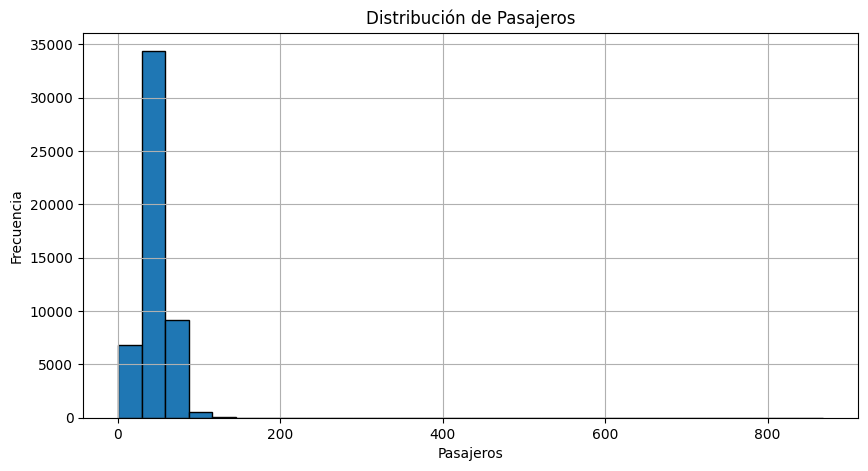

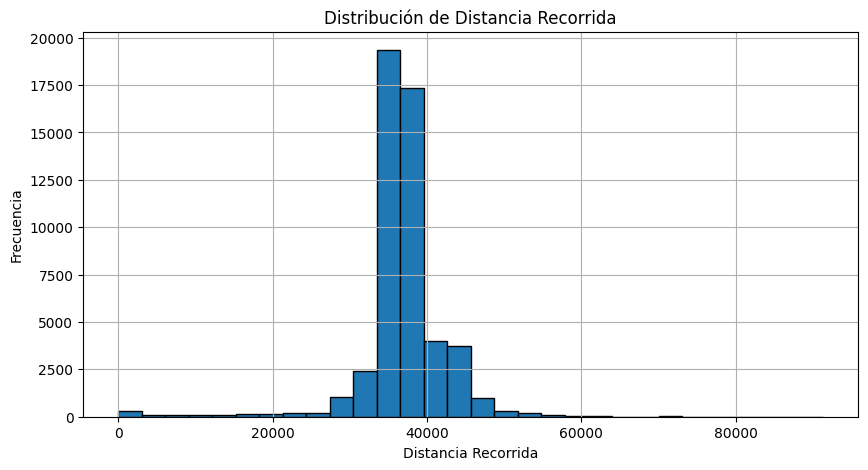

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_csv('Datos/despachos.csv')

# Estadísticas descriptivas
print(df.describe())

# Identificación de valores nulos
print(df.isnull().sum())

# Histogramas
plt.figure(figsize=(10, 5))
df['PASAJEROS'].hist(bins=30, edgecolor='black')
plt.xlabel('Pasajeros')
plt.ylabel('Frecuencia')
plt.title('Distribución de Pasajeros')
plt.show()

plt.figure(figsize=(10, 5))
df['DISTANCIA'].hist(bins=30, edgecolor='black')
plt.xlabel('Distancia Recorrida')
plt.ylabel('Frecuencia')
plt.title('Distribución de Distancia Recorrida')
plt.show()